#Multi-Model Merging via Spherical Barycenters (SLERP for n>2)

Obiettivi chiave del progetto 🔑
- Estensione dell'interpolazione lineare sferica (SLERP) al caso di n>2 modelli
- Implementazione di un approccio basato sul baricentro sferico
- Test dei merged models su task di image classification
- Implementare un ottimizzatore più avanzato della discesa del gradiente sulla sfera, come Riemannian Trust-Region
- creare un grafico delle loss lungo le traiettorie dei modelli, per confrontare SLERP, barycenter e interpolazioni lineari
- Analisi topologica dello spazio dei modelli per rilevare regioni che causano un peggioramento della performance

#Multi model merging su MLP

Questa cella di codice importa le librerie necessarie per il progetto, tra cui **torch** e torch.nn per la costruzione e l'addestramento di reti neurali, **torch.nn.functional** per le funzioni di attivazione e loss, **torchvision** per i dataset e le trasformazioni, **torch.utils.data** per la gestione dei dati e **numpy** per le operazioni numeriche.

In [ ]:
import torch
import torch.nn as nn #funzioni per costruzione di reti neurali
import torch.nn.functional as F #modulo functiona, funzioni per reti neurali (attivazione e loss)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

Questa cella definisce la classe **SimpleMLP**, un semplice modello di rete neurale multi-strato (MLP). La rete è composta da tre layer completamente connessi (**nn.Linear**) con funzioni di attivazione ReLU tra i primi due layer. Il metodo **forward** definisce il flusso dei dati attraverso la rete, appiattendo l'immagine di input e passandola attraverso i layer lineari e le attivazioni.

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #appiattiamo l'immagine in un vettore
        x = x.view(-1, 28*28)
        #passiamo il vettore attraverso il primo layer e applichiamo la funzione di attivazione ReLu
        x = F.relu(self.fc1(x))
        #passiamo il vettore attraverso il secondo layer e applichiamo la funzione di attivazione ReLu
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Questa cella definisce due funzioni: **train_model** per l'addestramento del modello utilizzando un ottimizzatore Adam e la loss CrossEntropyLoss, e **evaluate_model** per valutare l'accuratezza del modello su un dataloader fornito.

In [ ]:
def train_model(model, dataloader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            #ad ogni iterazione settiamo il gradiente a zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

Questa cella di codice implementa due funzioni chiave per il model merging: **slerp** per l'interpolazione lineare sferica tra due vettori (utilizzata implicitamente nel calcolo del baricentro iterativo) e **spherical_barycenter** per calcolare il baricentro sferico di un insieme di n vettori, un punto centrale che minimizza la somma pesata delle distanze geodetiche dagli altri vettori.

In [ ]:
#interpolazione lineare sferica
def slerp(v0, v1, t):
    #normalizzazione dei vettori
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    #prodotto scalare
    dot = np.clip(np.dot(v0, v1), -1.0, 1.0)
    omega = np.arccos(dot) #angolo che rappresenta la distanza geodetica tra i due vettori
    #se l'angolo è molto piccolo(i due vettori sono quasi paralleli) calcoliamo la distanza euclidea, invece che quella geodetica
    if np.isclose(omega, 0):
        return (1 - t) * v0 + t * v1
    return (np.sin((1 - t) * omega) * v0 + np.sin(t * omega) * v1) / np.sin(omega) #distanza geodetica

#baricentro sferico di un insieme di n vettori
def spherical_barycenter(vectors, weights=None, max_iter=100, tol=1e-6):
    vectors = np.array(vectors)
    n = len(vectors)
    if weights is None:
        weights = np.ones(n) / n
    weights = np.array(weights)

    b = vectors[0].copy()
    for _ in range(max_iter):
        grad = np.zeros_like(b)
        for v, w in zip(vectors, weights):
            dot = np.clip(np.dot(b, v), -1.0, 1.0)
            angle = np.arccos(dot)
            if angle > 1e-6:
                grad += w * angle / np.sin(angle) * (v - dot * b)
        if np.linalg.norm(grad) < tol:
            break
        b = b + grad
        b = b / np.linalg.norm(b)
    return b

Questa cella di codice definisce due funzioni di ausiliarie per manipolare i pesi del modello: **flatten_weights** per appiattire tutti i tensori dei pesi di un modello in un singolo vettore 1D, e **set_model_weights** per impostare i pesi di un modello a partire da un vettore 1D appiattito, ripristinando le forme originali dei tensori. Queste funzioni sono fondamentali per estrarre i pesi per il calcolo del baricentro e per riapplicare i pesi del baricentro al modello.

In [ ]:
def flatten_weights(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_model_weights(model, flat_weights):
    idx = 0
    for param in model.parameters():
        shape = param.data.shape
        size = param.data.numel()
        param.data = flat_weights[idx:idx+size].view(shape).clone()
        idx += size

Questa cella di codice carica il dataset MNIST, applica una trasformazione per convertirlo in tensori e lo divide in set di addestramento e validazione. Infine, crea i DataLoader per entrambi i set per facilitare l'iterazione sui dati durante l'addestramento e la valutazione del modello.

In [ ]:
#caricamento dei dati

transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, val_set = random_split(mnist, [50000, 10000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]


Questa cella addestra tre modelli **SimpleMLP** indipendenti, ognuno inizializzato con un diverso seed casuale. Questo viene fatto per ottenere modelli con parametri iniziali differenti, che verranno poi utilizzati per effettuare il model merging.

In [ ]:
#addestramento dei modelli
models = []
for seed in [0, 1, 2, 3]:
    torch.manual_seed(seed)
    model = SimpleMLP()
    train_model(model, train_loader, epochs=3)
    models.append(model)

Questa cella di codice estrae i tensori dei pesi da ciascuno dei modelli MLP addestrati e li appiattisce in vettori 1D utilizzando la funzione **flatten_weights**. Successivamente, normalizza ciascun vettore di peso dividendo per la sua norma, preparando i vettori per il calcolo del baricentro sferico.

In [ ]:
#estrazione e normalizzazione dei pesi
weight_vectors = [flatten_weights(m).numpy() for m in models]
normed_vectors = [v / np.linalg.norm(v) for v in weight_vectors]

Questa cella calcola il baricentro sferico dei vettori di peso normalizzati dei modelli MLP utilizzando la funzione **spherical_barycenter**. Successivamente, crea un nuovo modello **SimpleMLP** e imposta i suoi pesi sul vettore del baricentro calcolato utilizzando la funzione **set_model_weights**.

In [ ]:
#calcolo del baricentro
barycenter_vector = spherical_barycenter(normed_vectors)
bary_model = SimpleMLP()
set_model_weights(bary_model, torch.tensor(barycenter_vector, dtype=torch.float32))

Questa cella di codice valuta l'accuratezza dei quattro modelli **SimpleMLP** individuali addestrati e del modello ottenuto calcolando il baricentro sferico dei loro pesi.

In [ ]:
accuracies = {
    f"Model {i+1}": evaluate_model(m, val_loader)
    for i, m in enumerate(models)
}
accuracies["Merged models via Barycenter"] = evaluate_model(bary_model, val_loader)

print(accuracies)

{'Model 1': 0.9627, 'Model 2': 0.9639, 'Model 3': 0.9637, 'Model 4': 0.9621, 'Merged models via Barycenter': 0.0872}


##Multi model merging su regressione logistica

Applichiamo lo stesso processo sul modello di regressione logistica.

In [ ]:
#definiamo il modello di regressione logistica con layer lineare
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

In [ ]:
logistic_models = []
for seed in [0, 1, 2, 3]:
    torch.manual_seed(seed)
    model = LogisticRegression()
    train_model(model, train_loader, epochs=3)
    logistic_models.append(model)

In [ ]:
logistic_weight_vectors = [flatten_weights(m).numpy() for m in logistic_models]
normed_logistic_vectors = [v / np.linalg.norm(v) for v in logistic_weight_vectors]

In [ ]:
logistic_barycenter_vector = spherical_barycenter(normed_logistic_vectors)

In [ ]:
logistic_bary_model = LogisticRegression()
set_model_weights(logistic_bary_model, torch.tensor(logistic_barycenter_vector, dtype=torch.float32))

In [ ]:
logistic_accuracies = {}
for i, model in enumerate(logistic_models):
    accuracy = evaluate_model(model, val_loader)
    logistic_accuracies[f"Logistic Model {i+1}"] = accuracy

barycenter_accuracy = evaluate_model(logistic_bary_model, val_loader)
logistic_accuracies["Merged Logistic models via Barycenter"] = barycenter_accuracy

print(logistic_accuracies)

{'Logistic Model 1': 0.9158, 'Logistic Model 2': 0.915, 'Logistic Model 3': 0.9177, 'Logistic Model 4': 0.9164, 'Merged Logistic models via Barycenter': 0.9176}


#Rimannian Trust Region optimizer

Implementiamo un ottimizzatore alternativo alla discesa del gradiente, per verificare se nel caso di MLP un ottimizzatore migliore avrebbe potuto portare ad un significativo aumento dell'accuracy.

In [ ]:
#Riemannian trust region optimizer

import scipy.optimize
from scipy.linalg import svd

def riemannian_trust_region_barycenter(vectors, weights=None, max_iter=100, tol=1e-6):
    #Calcola il baricentro sferico usando l'ottimizzazione Riemannian Trust-Region
    vectors = np.array(vectors)
    n = len(vectors)
    if weights is None:
        weights = np.ones(n) / n
    weights = np.array(weights)

    def objective(x):
        x = x / np.linalg.norm(x)
        total = 0.0
        for v, w in zip(vectors, weights):
            dot = np.clip(np.dot(x, v), -1.0, 1.0)
            angle = np.arccos(dot)
            total += w * angle**2
        return total

    #Definizione del Gradiente Riemanniano
    def gradient(x):
        x_norm = x / np.linalg.norm(x)
        grad_euclidean = np.zeros_like(x)
        for v, w in zip(vectors, weights):
            dot = np.clip(np.dot(x_norm, v), -1.0, 1.0)
            angle = np.arccos(dot)
            if angle > 1e-6:
                grad_euclidean += w * angle / np.sin(angle) * (v - dot * x_norm)

        grad_riemannian = grad_euclidean - np.dot(grad_euclidean, x_norm) * x_norm
        return grad_riemannian

    #Hessiano approssimato
    def hessian(x, p):
        x_norm = x / np.linalg.norm(x)
        p_norm = p / np.linalg.norm(p)

        h = np.zeros_like(x)
        for v, w in zip(vectors, weights):
            dot = np.clip(np.dot(x_norm, v), -1.0, 1.0)
            angle = np.arccos(dot)
            if angle > 1e-6:
                term = (v - dot * x_norm) / np.sin(angle)
                h += w * (np.dot(term, p_norm) * term + angle * (-dot * p_norm))

        h = h - np.dot(h, x_norm) * x_norm
        return h

    # Punto iniziale
    x0 = np.mean(vectors, axis=0)
    x0 = x0 / np.linalg.norm(x0)

    #Ottimizzazione con trust-region
    result = scipy.optimize.minimize(
        objective,
        x0,
        method='trust-krylov',
        jac=gradient,
        hessp=hessian,
        options={'maxiter': max_iter, 'gtol': tol}
    )

    return result.x / np.linalg.norm(result.x)



#Calcolo del baricentro con Riemannian Trust-Region
rt_barycenter_vector = riemannian_trust_region_barycenter(normed_vectors)
rt_bary_model = SimpleMLP()
set_model_weights(rt_bary_model, torch.tensor(rt_barycenter_vector, dtype=torch.float32))
rt_accuracy = evaluate_model(rt_bary_model, val_loader)

print(f"Riemannian Trust-Region Barycenter Accuracy: {rt_accuracy:.4f}")

Riemannian Trust-Region Barycenter Accuracy: 0.0941


##Analisi topologica
In questa cella, grafichiamo la loss nello spazio dei modelli per osservare la presenza di aree in cui la loss è più alta.

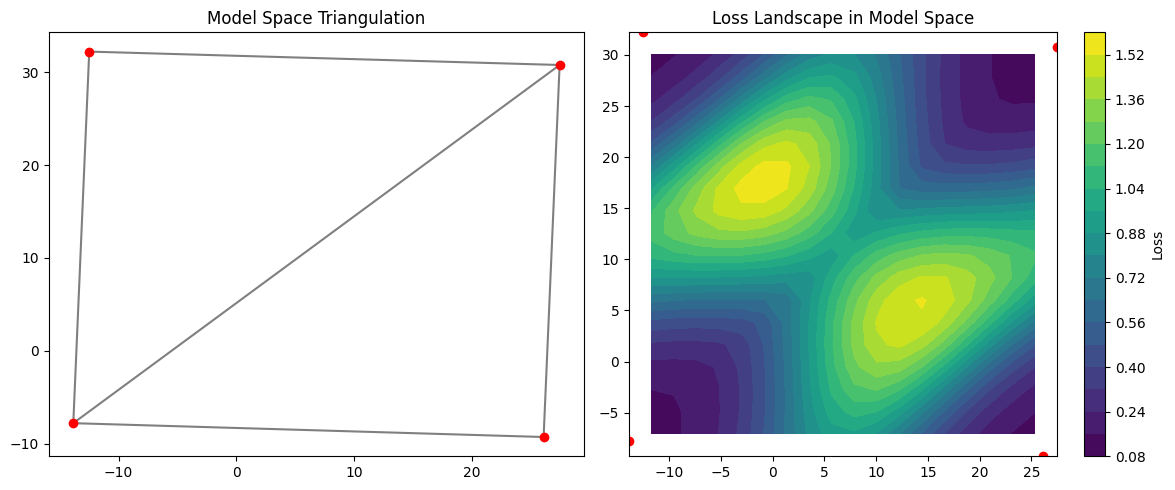

Trovate regioni con loss significativamente più alta della media (0.797)


In [ ]:
#analisi topologica spazio dei modelli

from sklearn.manifold import TSNE
from scipy.spatial import Delaunay

def topological_analysis(models, val_loader, model_class):
    """Analisi topologica dello spazio dei modelli"""
    # Estrai i pesi e convertili in array numpy
    weights = np.array([flatten_weights(m).numpy() for m in models])  # Converti in array numpy

    # Riduci la dimensionalità con t-SNE
    perplexity = min(5, len(weights)-1)  # Assicurati che perplexity < n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity)
    weights_tsne = tsne.fit_transform(weights)

    # Calcola la triangolazione di Delaunay
    tri = Delaunay(weights_tsne)

    # Crea una griglia per valutare la performance
    x_min, x_max = weights_tsne[:,0].min(), weights_tsne[:,0].max()
    y_min, y_max = weights_tsne[:,1].min(), weights_tsne[:,1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20),
                         np.linspace(y_min, y_max, 20))

    # Per ogni punto nella griglia, trova il modello interpolato e valuta la loss
    losses = np.zeros_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = np.array([xx[i,j], yy[i,j]])
            # Trova il simplesso che contiene il punto
            simplex_idx = tri.find_simplex(point)
            if simplex_idx >= 0:
                # Interpolazione baricentrica
                vertices = tri.simplices[simplex_idx]
                bary_coords = tri.transform[simplex_idx, :2].dot(
                    point - tri.transform[simplex_idx, 2])
                bary_coords = np.append(bary_coords, 1 - bary_coords.sum())

                # Interpola i pesi
                interp_weights = sum(bary_coords[k] * weights[vertices[k]]
                                    for k in range(3))
                model = model_class() # Use the provided model_class
                set_model_weights(model, torch.tensor(interp_weights, dtype=torch.float32))
                losses[i,j] = evaluate_loss(model, val_loader)
            else:
                losses[i,j] = np.nan

    # Visualizzazione
    plt.figure(figsize=(12, 5))

    # Plot della triangolazione
    plt.subplot(121)
    plt.triplot(weights_tsne[:,0], weights_tsne[:,1], tri.simplices, 'k-', alpha=0.5)
    plt.scatter(weights_tsne[:,0], weights_tsne[:,1], c='r', label='Models')
    plt.title('Model Space Triangulation')

    # Plot della loss surface
    plt.subplot(122)
    contour = plt.contourf(xx, yy, losses, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Loss')
    plt.scatter(weights_tsne[:,0], weights_tsne[:,1], c='r')
    plt.title('Loss Landscape in Model Space')

    plt.tight_layout()
    plt.show()

    # Identifica regioni con alta loss
    avg_loss = np.nanmean(losses)
    high_loss_regions = losses > avg_loss + 0.1
    if np.any(high_loss_regions):
        print(f"Trovate regioni con loss significativamente più alta della media ({avg_loss:.3f})")
    else:
        print("Nessuna regione con loss significativamente più alta della media trovata")


# 3. Analisi topologica
topological_analysis(models, val_loader, SimpleMLP)

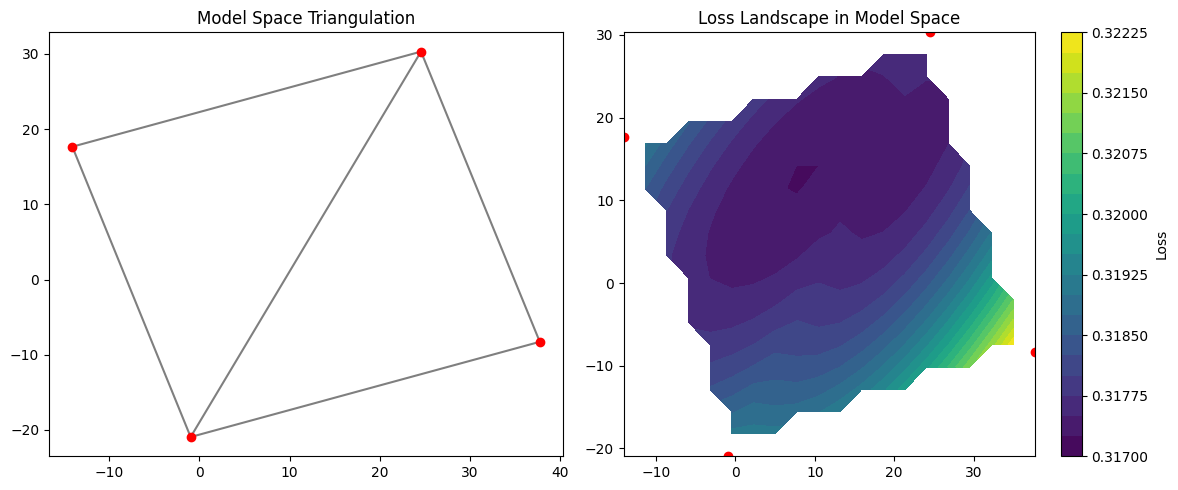

Nessuna regione con loss significativamente più alta della media trovata


In [ ]:
# Analisi topologica per i modelli di regressione logistica
topological_analysis(logistic_models, val_loader, LogisticRegression)

In [ ]:
# Calcola il baricentro con il metodo iterativo precedente
barycenter_vector_iterative = spherical_barycenter(normed_vectors)
bary_model_iterative = SimpleMLP()
set_model_weights(bary_model_iterative, torch.tensor(barycenter_vector_iterative, dtype=torch.float32))
accuracy_iterative = evaluate_model(bary_model_iterative, val_loader)
print(f"Iterative Barycenter Accuracy: {accuracy_iterative:.4f}")

# Calcola il baricentro con il metodo Riemannian Trust-Region
rt_barycenter_vector = riemannian_trust_region_barycenter(normed_vectors)
rt_bary_model = SimpleMLP()
set_model_weights(rt_bary_model, torch.tensor(rt_barycenter_vector, dtype=torch.float32))
accuracy_rt = evaluate_model(rt_bary_model, val_loader)
print(f"Riemannian Trust-Region Barycenter Accuracy: {accuracy_rt:.4f}")

# Confronto delle accuratezze
if accuracy_rt > accuracy_iterative:
    print("Il metodo Riemannian Trust-Region ha prodotto un modello con accuratezza maggiore.")
elif accuracy_rt < accuracy_iterative:
    print("Il metodo iterativo ha prodotto un modello con accuratezza maggiore.")
else:
    print("Entrambi i metodi hanno prodotto modelli con accuratezza simile.")

Iterative Barycenter Accuracy: 0.0941
Riemannian Trust-Region Barycenter Accuracy: 0.0941
Entrambi i metodi hanno prodotto modelli con accuratezza simile.


##**Coerenza Ciclica del Baricentro Sferico**

Un aspetto fondamentale del merging di più di due modelli è la **coerenza ciclica**. Questa proprietà ci assicura che il risultato finale del modello unito sia unico, indipendentemente dal percorso o dall'ordine in cui i modelli sono stati combinati. L'uso della SLERP in modo iterativo per fondere più modelli non garantisce questa proprietà, poiché l'ordine delle operazioni può portare a risultati diversi.

Invece, la nostra implementazione del baricentro sferico risolve questo problema in modo implicito. Calcolando la media ponderata di tutti i vettori di peso in un singolo passaggio, il baricentro sferico trova un punto unico che rappresenta la 'posizione centrale' di tutti i modelli, rendendo il risultato del merging per sua natura ciclo-coerente. Questo approccio elimina l'ambiguità e garantisce un modello unificato stabile."


In [ ]:
# Calcoliamo il baricentro sferico con gli stessi vettori in ordini diversi

# Ordine M1, M2, M3, M4
barycenter_order1 = spherical_barycenter([normed_logistic_vectors[0], normed_logistic_vectors[1], normed_logistic_vectors[2], normed_logistic_vectors[3]])

# Ordine M4, M2, M1, M3
barycenter_order2 = spherical_barycenter([normed_logistic_vectors[3], normed_logistic_vectors[1], normed_logistic_vectors[0], normed_logistic_vectors[2]])


are_cyclically_consistent = np.allclose(barycenter_order1, barycenter_order2, atol=1e-6)

print(f"Barycenter vector (Order 1): {barycenter_order1[:5]}...")
print(f"Barycenter vector (Order 2): {barycenter_order2[:5]}...")
print(f"I vettori del baricentro calcolati con ordini diversi sono quasi identici (entro una tolleranza di 1e-6): {are_cyclically_consistent}")

if are_cyclically_consistent:
    print("Questo dimostra empiricamente la coerenza ciclica della funzione spherical_barycenter.")
else:
    print("I vettori del baricentro calcolati con ordini diversi non sono abbastanza vicini.")

Barycenter vector (Order 1): [-0.00016501 -0.00060417 -0.00076264 -0.00082374 -0.000621  ]...
Barycenter vector (Order 2): [-0.00016501 -0.00060417 -0.00076264 -0.00082374 -0.000621  ]...
I vettori del baricentro calcolati con ordini diversi sono quasi identici (entro una tolleranza di 1e-6): True
Questo dimostra empiricamente la coerenza ciclica della funzione spherical_barycenter.
